<a href="https://colab.research.google.com/github/danielbarasa/klasifikasi-batik/blob/main/Classificationacase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mengambil dataset dari github


In [1]:
!apt-get install subversion > /dev/null

!svn export https://github.com/danielbarasa/klasifikasi-batik/trunk/image > /dev/null

# Persiapan

## memasukkan fungsi Library

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # The %tensorflow_version magic only works in colab.
  %tensorflow_version 2.x
except Exception:
  pass
import numpy as np 
import math, os, sys
import itertools

import matplotlib.pyplot as plt
plt.style.use('default')
from scipy import ndimage

from skimage import measure, morphology
from skimage.io import imsave, imread
from skimage.filters import threshold_otsu
from skimage.transform import resize

import tensorflow as tf
from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix
import pandas as pd

# Mengimport dataset

In [3]:
#Perintah di bawah ini untuk melihat list bagian dari file yang sudah diunduh dari Github
!ls image
!ls image/train
!ls image/train/Kawung
!ls image/train/Parang
!ls image/train/Cendrawasih

test  train
Cendrawasih  Kawung  Parang
0.jpg	16.jpg	22.jpg	29.jpg	35.jpg	41.jpg	48.jpg	54.jpg	60.jpg	67.jpg
10.jpg	17.jpg	23.jpg	2.jpg	36.jpg	42.jpg	49.jpg	55.jpg	61.jpg	68.jpg
11.jpg	18.jpg	24.jpg	30.jpg	37.jpg	43.jpg	4.jpg	56.jpg	62.jpg	69.jpg
12.jpg	19.jpg	25.jpg	31.jpg	38.jpg	44.jpg	50.jpg	57.jpg	63.jpg	6.jpg
13.jpg	1.jpg	26.jpg	32.jpg	39.jpg	45.jpg	51.jpg	58.jpg	64.jpg	7.jpg
14.jpg	20.jpg	27.jpg	33.jpg	3.jpg	46.jpg	52.jpg	59.jpg	65.jpg	8.jpg
15.jpg	21.jpg	28.jpg	34.jpg	40.jpg	47.jpg	53.jpg	5.jpg	66.jpg	9.jpg
0.jpg	16.jpg	22.jpg	29.jpg	35.jpg	41.jpg	48.jpg	54.jpg	60.jpg	67.jpg
10.jpg	17.jpg	23.jpg	2.jpg	36.jpg	42.jpg	49.jpg	55.jpg	61.jpg	68.jpg
11.jpg	18.jpg	24.jpg	30.jpg	37.jpg	43.jpg	4.jpg	56.jpg	62.jpg	69.jpg
12.jpg	19.jpg	25.jpg	31.jpg	38.jpg	44.jpg	50.jpg	57.jpg	63.jpg	6.jpg
13.jpg	1.jpg	26.jpg	32.jpg	39.jpg	45.jpg	51.jpg	58.jpg	64.jpg	7.jpg
14.jpg	20.jpg	27.jpg	33.jpg	3.jpg	46.jpg	52.jpg	59.jpg	65.jpg	8.jpg
15.jpg	21.jpg	28.jpg	34.jpg	40.jpg	47.jpg	53.jpg	5.jpg	66.jpg	9.jpg


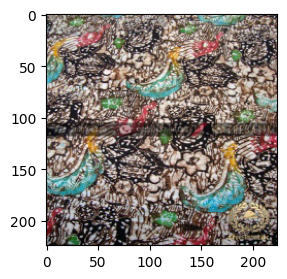

In [4]:
#Perintah untuk memvisualisasikan satu gambar dari data train
image = imread("image/train/Cendrawasih/0.jpg")
plt.figure(figsize=(3,3))
plt.imshow(image)

In [5]:
#Memuat semua gambar ke memori untuk pertama kali

#Memuat dataset pelatihan
X_train = []
y_train = []
labels = ['Kawung', 'Parang','Cendrawasih']

for i,label in enumerate(labels):
    folder = os.path.join("image/train",label)
    files = sorted(os.listdir(folder))
    files = [x for x in files if x.endswith(".jpg")]
    for k,file in enumerate(files):
        image_path = os.path.join(folder, file)
        
        image = imread(image_path)/255.
        image = resize(image,(224,224))
        X_train.append(image)
        category = os.path.split(folder)[-1]
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)

#Memuat dataset pengujian
X_test = []
y_test = []
labels = ['Kawung',  'Parang', 'Cendrawasih']

for i,label in enumerate(labels):
    folder = os.path.join("image/test",label)
    files = sorted(os.listdir(folder))
    files = [x for x in files if x.endswith(".jpg")]
    for k,file in enumerate(files):
        image_path = os.path.join(folder, file)
        
        image = imread(image_path)/255.
        image = resize(image,(224,224))
        X_test.append(image)
        category = os.path.split(folder)[-1]
        y_test.append(i)

X_test = np.array(X_test)
y_test = np.array(y_test)

print("Bentuk array dari dataset train (pelatihan) adalah:", X_train.shape,y_train.shape)
print("Bentuk array dari dataset test (pengujian) adalah:", X_test.shape,y_test.shape)

Bentuk array dari dataset train (pelatihan) adalah: (210, 224, 224, 3) (210,)
Bentuk array dari dataset test (pengujian) adalah: (60, 224, 224, 3) (60,)


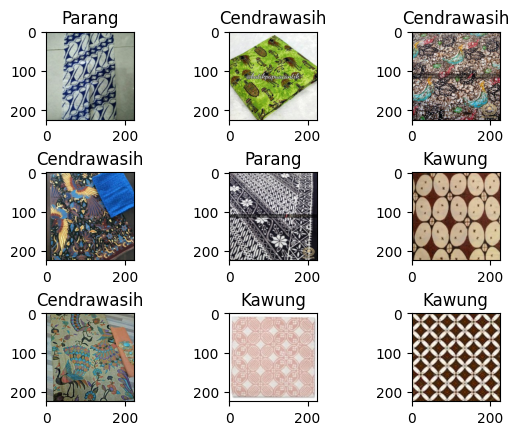

In [6]:
plt.subplots_adjust(wspace=0.4, hspace=0.6)

#Menampilkan beberapa gambar dari dataset pelatihan secara acak
index = np.random.randint(0,X_train.shape[0],size=9)

for i, idx  in enumerate(index):
    plt.subplot(3,3,i+1)
    
    if y_train[idx] == 0:
        label = "Kawung"
    if y_train[idx] == 1:
        label = "Parang"
    if  y_train[idx] == 2:
        label = "Cendrawasih"
    plt.title(label)
    plt.imshow(X_train[idx])

# menggunakan model pretrained

In [7]:
IMG_SHAPE = (224, 224, 3)
# Membuat model dasar (base model) dari pre-trained model MobileNet
base_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

17235968/17225924 [==============================] - 0s 0us/step


In [8]:
base_model.trainable = False
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

# Menmbuat klasifikasi dengan CNN

In [9]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras import layers
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import train_test_split

# Mempersiapkan data pengujian

In [10]:
y_train2 = to_categorical(y_train)
X_train3, X_valid3, y_train3, y_valid3 = train_test_split(X_train, y_train2, train_size=0.8, random_state=42)
y_test2 = to_categorical(y_test)
X_test3, y_test3 = (X_test, y_test2)

# Pembuatan model

In [11]:
model = tf.keras.Sequential([
    base_model,    
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile("adam",loss="categorical_crossentropy",metrics=["acc"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 32)          294944    
                                                                 
 global_average_pooling2d (G  (None, 32)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 3,523,907
Trainable params: 295,043
Non-trainable params: 3,228,864
_________________________________________________________________


# pelatihan

In [12]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

#Menyimpan file model bobot yang terbaik selama pelatihan (dalam format keras ".h5")
ckpt = ModelCheckpoint("Klasifikasi jenis batik.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
history = model.fit(x = X_train3, y = y_train3, batch_size=60, epochs= 100,validation_data=(X_valid3,y_valid3),callbacks = [ckpt])

Epoch 1/100
3/3 [==============================] - ETA: 0s - loss: 2.5959 - acc: 0.3571
Epoch 1: val_loss improved from inf to 0.90521, saving model to Klasifikasi jenis batik.h5
3/3 [==============================] - 10s 3s/step - loss: 2.5959 - acc: 0.3571 - val_loss: 0.9052 - val_acc: 0.4762
Epoch 2/100
3/3 [==============================] - ETA: 0s - loss: 0.5795 - acc: 0.7321
Epoch 2: val_loss improved from 0.90521 to 0.20905, saving model to Klasifikasi jenis batik.h5
3/3 [==============================] - 7s 2s/step - loss: 0.5795 - acc: 0.7321 - val_loss: 0.2090 - val_acc: 0.9524
Epoch 3/100
3/3 [==============================] - ETA: 0s - loss: 0.1815 - acc: 0.9583
Epoch 3: val_loss did not improve from 0.20905
3/3 [==============================] - 7s 2s/step - loss: 0.1815 - acc: 0.9583 - val_loss: 0.3184 - val_acc: 0.8810
Epoch 4/100
3/3 [==============================] - ETA: 0s - loss: 0.1307 - acc: 0.9583
Epoch 4: val_loss improved from 0.20905 to 0.13372, saving model t

# Menggambarkan hasil pelatihan

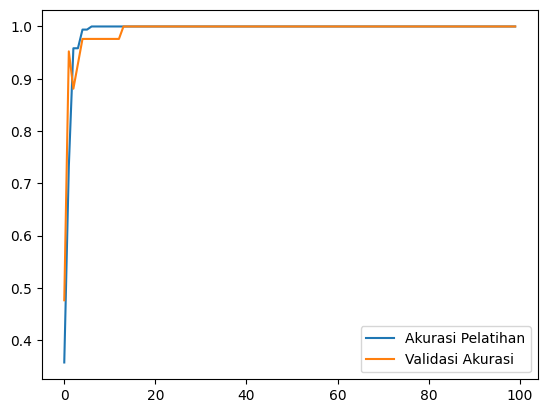

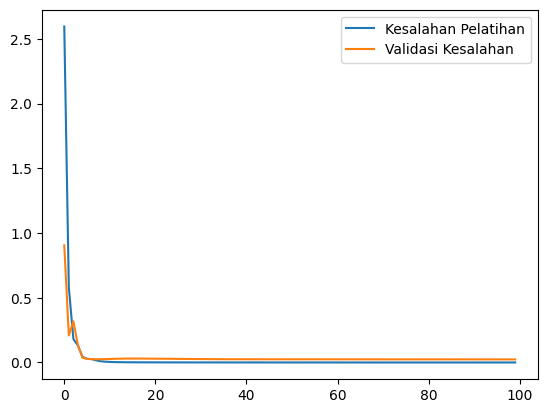

In [13]:
plt.plot(history.history["acc"],label="Akurasi Pelatihan")
plt.plot(history.history["val_acc"],label="Validasi Akurasi")
plt.legend()
plt.show()

plt.plot(history.history["loss"],label="Kesalahan Pelatihan")
plt.plot(history.history["val_loss"],label="Validasi Kesalahan")
plt.legend()
plt.show()

# menggunakan model

In [14]:
print(X_train3.shape)

(168, 224, 224, 3)


In [15]:
n = 40
input_image = X_train3[n][np.newaxis,...]
print("Labelnya adalah: ", y_train3[n])

predictions = model.predict(input_image)
print("Prediksinya adalah",predictions[0])

Labelnya adalah:  [0. 1. 0.]
Prediksinya adalah [8.639433e-09 1.000000e+00 9.750406e-16]


# evaluasi

In [16]:
#Memuat file bobot model keras ".h5" dengan paling sedikit data validasi yang hilang/error
#File ini akan dikonversi ke tensorflow lite
model.load_weights("Klasifikasi jenis batik.h5")

In [17]:
#Memeriksa matriks model
print(model.metrics_names)
#Evaluasi data training
print(model.evaluate(x= X_train3, y = y_train3))
#Evaluasi validasi data
print(model.evaluate(x= X_valid3, y = y_valid3))
#Evaluasi data test
print(model.evaluate(x= X_test3, y = y_test3)) 

['loss', 'acc']
6/6 [==============================] - 5s 875ms/step - loss: 1.3880e-04 - acc: 1.0000
[0.0001387989177601412, 1.0]
2/2 [==============================] - 1s 384ms/step - loss: 0.0238 - acc: 1.0000
[0.023781288415193558, 1.0]
2/2 [==============================] - 2s 941ms/step - loss: 0.0396 - acc: 0.9833
[0.039556264877319336, 0.9833333492279053]


In [18]:
#Menampilkan matriks yang benar dan matriks hasil prediksi

#Label yang benar
y_true = np.argmax(y_test2,axis=1)

#Label prediksi
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print(y_true)
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


# prediksi gambar individual 

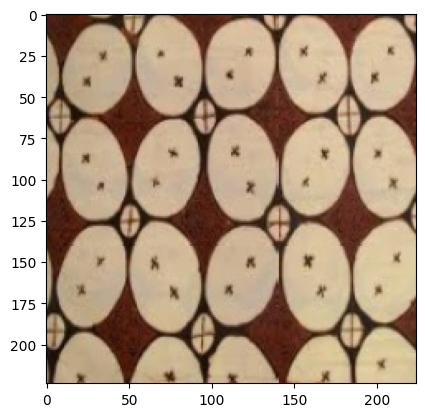

Label yang benar adalah: 0 : Kawung
Nilai yang diprediksi adalah: [9.9999976e-01 4.5944823e-08 1.9110624e-07]
Label yang diprediksi adalah: 0 : Kawung
Prediksi benar


In [19]:
n = 0 #Jangan melampaui (nilai dari gambar test - 1)

plt.imshow(X_test[n])
plt.show()

true_label = np.argmax(y_test2,axis=1)[n]
print("Label yang benar adalah:",true_label,":",labels[true_label])
prediction = model.predict(X_test[n][np.newaxis,...])[0]
print("Nilai yang diprediksi adalah:",prediction)
predicted_label = np.argmax(prediction)
print("Label yang diprediksi adalah:",predicted_label,":",labels[predicted_label])

if true_label == predicted_label:
    print("Prediksi benar")
else:
    print("Prediksi salah")